In [39]:
from astropy.io import fits
from astropy.nddata import Cutout2D
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm

In [104]:
def deprojection(inputarray,h0,r0,alpha,inc,PA,dist,extent,resolution):
    pix = np.tan((resolution/10)*np.pi/180)*dist
    print('AU/Pixel = ',pix)
    
    rotarray = ndimage.rotate(inputarray,22.11)
    interparray = ndimage.zoom(rotarray,(10,10))
    centrepoint = (len(interparray[0])/2,len(interparray)/2)
    
    outarray = np.ones(interparray.shape)
    
    R = []
    xy = []
    for y in tqdm(range(len(interparray))):
        for x in range(len(interparray[0])):
            xy.append((x-centrepoint[0],y-centrepoint[1]))
            rpix = np.sqrt(np.abs(x-centrepoint[0])**2 + np.abs(y-centrepoint[1])**2)
            r = rpix * pix
            R.append(r)
            if r < extent:
                u = h0*(r/r0)**alpha * np.sin(inc*np.pi/180)
                ux = x
                uy = y + round(u/pix)
                
                outarray[uy][ux]=interparray[y][x]

    stretcharray = ndimage.zoom(outarray,(1/np.cos(inc*np.pi/180),1))
    
    return stretcharray

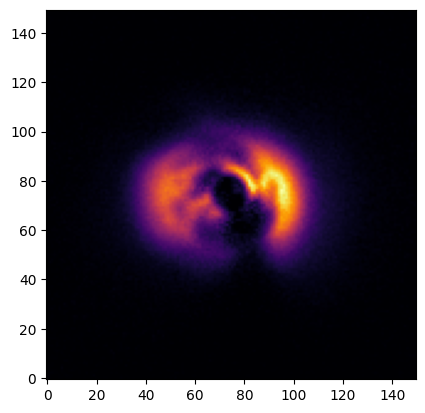

In [105]:
ATPyx = fits.open('fits/AT_Pyx_2024-01-17_Q_phi.fits')[0].data


ATPyx = np.array(Cutout2D(ATPyx,(len(ATPyx[0])/2,len(ATPyx)/2),(150,150)).data)

plt.imshow(ATPyx,origin='lower',cmap='inferno',vmin=0)


In [106]:
ATPyxDeproj = deprojection(ATPyx,
                          h0=0.1617*100,
                          r0=100,
                          alpha=1.219,
                          inc=38.5,
                          PA=22.11,
                          dist=7.632e7,
                          extent=300,
                          resolution=3.40305e-6,)

AU/Pixel =  0.45329826770346676


100%|██████████████████████████████████████| 1950/1950 [00:15<00:00, 126.65it/s]


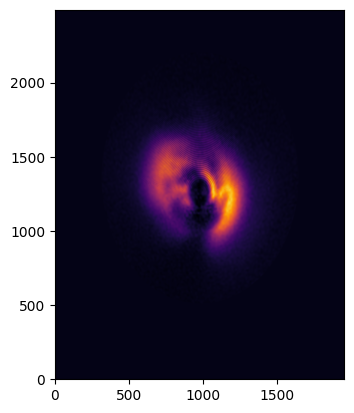

In [107]:
plt.imshow(ATPyxDeproj,origin='lower',cmap='inferno')
#x = 500400
#print(ATPyxDeproj[1][x],'-',ATPyxDeproj[2][x])